**Importing Libraries and Dataset**

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from plotly.graph_objects import Figure
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [89]:
pip install scikit-learn==1.2.2

In [2]:
df=pd.read_csv("/content/bank-additional-full.csv",delimiter=';')
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Data Preprocessing**

In [6]:
#Dropping unknown values of 'job','marital', 'housing' and 'loan'
df = df[(df['job'] != 'unknown') & (df['marital'] != 'unknown') & (df['loan'] != 'unknown') & (df['housing'] != 'unknown')]

In [7]:
#Imputing 'default' via KNNImputer
df['default'] = df['default'].map({'no': 0, 'yes': 1, 'unknown': np.nan})
columns_for_imputation = df.select_dtypes(include=[np.number]).columns
knn_imputer = KNNImputer(n_neighbors=5)
df[columns_for_imputation] = knn_imputer.fit_transform(df[columns_for_imputation])

<ipython-input-7-93f5d362ff75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['default'] = df['default'].map({'no': 0, 'yes': 1, 'unknown': np.nan})


Text(0.5, 1.0, 'Distribution of Default')

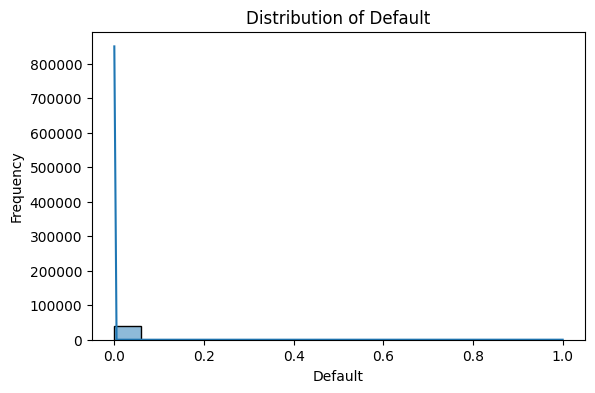

In [8]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
sns.histplot(df['default'], kde=True)
plt.xlabel("Default")
plt.ylabel("Frequency")
plt.title("Distribution of Default")

**Data Transformation**

In [9]:
skew_threshold = 0.5
numeric_columns = ['age','duration', 'campaign', 'pdays',
       'previous','emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']
skewed_features = [col for col in numeric_columns if df[col].skew() > skew_threshold ]
skewed_features

['age', 'duration', 'campaign', 'previous']

In [10]:
pt = PowerTransformer()
df_transformed = df.copy()
for col in skewed_features:
    df_transformed[col] = pt.fit_transform(df_transformed[[col]])

In [11]:
df_transformed.duplicated().sum()

14

In [12]:
df_transformed.drop_duplicates(inplace=True, keep='first')

**Data Encoding**

In [13]:
numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns
categorical_cols = df_transformed.select_dtypes(include=[object]).columns

# Create DataFrames for numeric and categorical data
df_numeric = df_transformed[numeric_cols]
df_categorical = df_transformed[categorical_cols]

In [14]:
feature_groups = {
  'job': {  # Group similar job types
    'admin.': 'Management & Administration',
    'management': 'Management & Administration',
    'blue-collar': 'Blue-collar & Service',
    'services': 'Blue-collar & Service',
    'professional.course': 'Professional & Technical',
    'technician': 'Professional & Technical',
    'entrepreneur': 'Business & Self-Employed',
    'self-employed': 'Business & Self-Employed',
    'student': 'Non-Active Workforce',
    'unemployed': 'Non-Active Workforce',
    'retired': 'Non-Active Workforce',
    'housemaid': 'Housemaid'
  },
  'education': {  # Group by attainment level
    'basic.4y': 'Basic & Secondary',
    'basic.6y': 'Basic & Secondary',
    'basic.9y': 'Basic & Secondary',
    'high.school': 'Basic & Secondary',
    'professional.course': 'Vocational/Professional & University',
    'university.degree': 'Vocational/Professional & University',
    'illiterate': 'Others',
    'unknown': 'Others'
  },
  'month': {  # Seasonal encoding for month
    'jan': 'Winter',
    'feb': 'Winter',
    'mar': 'Spring',
    'apr': 'Spring',
    'may': 'Spring',
    'jun': 'Summer',
    'jul': 'Summer',
    'aug': 'Summer',
    'sep': 'Fall',
    'oct': 'Fall',
    'nov': 'Fall',
    'dec': 'Winter'
  }
}

In [15]:
for col, group_map in feature_groups.items():
  df_categorical[f'{col}_group'] = df_categorical[col].map(group_map)

<ipython-input-15-cac6ffff0319>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical[f'{col}_group'] = df_categorical[col].map(group_map)
<ipython-input-15-cac6ffff0319>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical[f'{col}_group'] = df_categorical[col].map(group_map)
<ipython-input-15-cac6ffff0319>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [16]:
df_categorical

,job,marital,education,housing,loan,contact,month,day_of_week,poutcome,y,job_group,education_group,month_group
0,housemaid,married,basic.4y,no,no,telephone,may,mon,nonexistent,no,Housemaid,Basic & Secondary,Spring
1,services,married,high.school,no,no,telephone,may,mon,nonexistent,no,Blue-collar & Service,Basic & Secondary,Spring
2,services,married,high.school,yes,no,telephone,may,mon,nonexistent,no,Blue-collar & Service,Basic & Secondary,Spring
3,admin.,married,basic.6y,no,no,telephone,may,mon,nonexistent,no,Management & Administration,Basic & Secondary,Spring
4,services,married,high.school,no,yes,telephone,may,mon,nonexistent,no,Blue-collar & Service,Basic & Secondary,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,yes,no,cellular,nov,fri,nonexistent,yes,Non-Active Workforce,Vocational/Professional & University,Fall
41184,blue-collar,married,professional.course,no,no,cellular,nov,fri,nonexistent,no,Blue-collar & Service,Vocational/Professional & University,Fall
41185,retired,married,university.degree,yes,no,cellular,nov,fri,nonexistent,no,Non-Active Workforce,Vocational/Professional & University,Fall
41186,technician,married,professional.course,no,no,cellular,nov,fri,nonexistent,yes,Professional & Technical,Vocational/Professional & University,Fall


In [17]:
df_categorical.drop(feature_groups.keys(), axis=1, inplace=True)

<ipython-input-17-e4d4877f49bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categorical.drop(feature_groups.keys(), axis=1, inplace=True)


In [18]:
df_categorical

,marital,housing,loan,contact,day_of_week,poutcome,y,job_group,education_group,month_group
0,married,no,no,telephone,mon,nonexistent,no,Housemaid,Basic & Secondary,Spring
1,married,no,no,telephone,mon,nonexistent,no,Blue-collar & Service,Basic & Secondary,Spring
2,married,yes,no,telephone,mon,nonexistent,no,Blue-collar & Service,Basic & Secondary,Spring
3,married,no,no,telephone,mon,nonexistent,no,Management & Administration,Basic & Secondary,Spring
4,married,no,yes,telephone,mon,nonexistent,no,Blue-collar & Service,Basic & Secondary,Spring
...,...,...,...,...,...,...,...,...,...,...
41183,married,yes,no,cellular,fri,nonexistent,yes,Non-Active Workforce,Vocational/Professional & University,Fall
41184,married,no,no,cellular,fri,nonexistent,no,Blue-collar & Service,Vocational/Professional & University,Fall
41185,married,yes,no,cellular,fri,nonexistent,no,Non-Active Workforce,Vocational/Professional & University,Fall
41186,married,no,no,cellular,fri,nonexistent,yes,Professional & Technical,Vocational/Professional & University,Fall


In [19]:
target_mapping = {'yes': 1, 'no': 0}
df_categorical.loc[:, 'y'] = df_categorical['y'].map(target_mapping)
df_categorical.head()

,marital,housing,loan,contact,day_of_week,poutcome,y,job_group,education_group,month_group
0,married,no,no,telephone,mon,nonexistent,0,Housemaid,Basic & Secondary,Spring
1,married,no,no,telephone,mon,nonexistent,0,Blue-collar & Service,Basic & Secondary,Spring
2,married,yes,no,telephone,mon,nonexistent,0,Blue-collar & Service,Basic & Secondary,Spring
3,married,no,no,telephone,mon,nonexistent,0,Management & Administration,Basic & Secondary,Spring
4,married,no,yes,telephone,mon,nonexistent,0,Blue-collar & Service,Basic & Secondary,Spring


In [20]:
df_categorical.info()
df_categorical['marital'].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 39789 entries, 0 to 41187
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   marital          39789 non-null  object
 1   housing          39789 non-null  object
 2   loan             39789 non-null  object
 3   contact          39789 non-null  object
 4   day_of_week      39789 non-null  object
 5   poutcome         39789 non-null  object
 6   y                39789 non-null  object
 7   job_group        39789 non-null  object
 8   education_group  39789 non-null  object
 9   month_group      39789 non-null  object
dtypes: object(10)
memory usage: 4.3+ MB


array(['married', 'single', 'divorced'], dtype=object)

In [21]:
encode_df=df_categorical.drop(columns='y')

In [22]:
df_categorical.columns

Index(['marital', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome', 'y',
       'job_group', 'education_group', 'month_group'],
      dtype='object')

In [23]:
categorical_cols = ["marital", "housing", "loan", "contact", "day_of_week",
                   "poutcome", "job_group", "education_group", "month_group"]
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(encode_df[categorical_cols])
encoded_col_names = encoder.get_feature_names_out(categorical_cols)
encoded_features = encoder.transform(encode_df[categorical_cols])

In [24]:
encoded_features_dense = encoded_features.toarray()
encoded_df = encode_df.assign(**dict(zip(encoded_col_names, encoded_features_dense.T)))

In [25]:
encoded_df=encoded_df.drop(columns=["marital", "housing", "loan", "contact", "day_of_week",
                   "poutcome", "job_group", "education_group", "month_group"],axis=1)

In [26]:
combined_df = pd.concat([df_numeric , df_categorical, encoded_df], axis=1)
combined_df.head(3)

,age,default,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,job_group_Business & Self-Employed,job_group_Housemaid,job_group_Management & Administration,job_group_Non-Active Workforce,job_group_Professional & Technical,education_group_Others,education_group_Vocational/Professional & University,month_group_Spring,month_group_Summer,month_group_Winter
0,1.432350,0.0,0.388309,-1.045918,999.0,-0.3975,1.1,93.994,-36.4,4.857,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.497065,0.0,-0.236012,-1.045918,999.0,-0.3975,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.153310,0.0,0.223568,-1.045918,999.0,-0.3975,1.1,93.994,-36.4,4.857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
combined_df=combined_df.drop(columns=["marital","housing", "loan", "contact", "day_of_week",
                   "poutcome", "job_group", "education_group", "month_group"],axis=1)

In [28]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39789 entries, 0 to 41187
Data columns (total 33 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   age                                                   39789 non-null  float64
 1   default                                               39789 non-null  float64
 2   duration                                              39789 non-null  float64
 3   campaign                                              39789 non-null  float64
 4   pdays                                                 39789 non-null  float64
 5   previous                                              39789 non-null  float64
 6   emp.var.rate                                          39789 non-null  float64
 7   cons.price.idx                                        39789 non-null  float64
 8   cons.conf.idx                                         39789 n

In [29]:
combined_df['y'] = pd.to_numeric(combined_df['y'])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39789 entries, 0 to 41187
Data columns (total 33 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   age                                                   39789 non-null  float64
 1   default                                               39789 non-null  float64
 2   duration                                              39789 non-null  float64
 3   campaign                                              39789 non-null  float64
 4   pdays                                                 39789 non-null  float64
 5   previous                                              39789 non-null  float64
 6   emp.var.rate                                          39789 non-null  float64
 7   cons.price.idx                                        39789 non-null  float64
 8   cons.conf.idx                                         39789 n

In [30]:
combined_df['y'].unique()

array([0, 1])

In [31]:
combined_df.duplicated().sum()

7

In [32]:
combined_df.drop_duplicates(inplace=True, keep='first')

**Feature Selection**

In [33]:
fig = Figure()
corr_matrix = combined_df.corr()
corr_matrix_data = corr_matrix.values.tolist()

row_labels = corr_matrix.index.to_numpy()
col_labels = corr_matrix.columns.to_numpy()
fig = Figure(layout=dict(width=800, height=800))
fig.add_trace(dict(
    z=corr_matrix_data,
    x=col_labels,
    y=row_labels.tolist(),
    type='heatmap',
    colorscale='electric'
))
fig.update_layout(
    title='Correlation Heatmap',
    xaxis_title='Features',
    yaxis_title='Features'
)
fig.update_traces(colorbar=dict(dtick=0.2))
fig.show()


In [34]:
df_subset = combined_df[['y', 'default']]

corr_matrix = df_subset.corr(method='spearman')
corr_matrix_data = corr_matrix.values.tolist()
row_labels = corr_matrix.index.to_numpy()
col_labels = corr_matrix.columns.to_numpy()

fig = Figure()
fig.add_trace(dict(
    z=corr_matrix_data,
    x=col_labels,
    y=row_labels.tolist(),
    type='heatmap',
    colorscale='electric'
))

fig.update_layout(
    title='Correlation Heatmap (y vs. default)',
    xaxis_title='Features',
    yaxis_title='Features'
)
fig.update_traces(colorbar=dict(dtick=0.2))
fig.show()

As analysed here and in previous Analysis, 'default' does not play important role in predicting target variable so , dropping it too.

In [35]:
combined_df=combined_df.drop(columns=['day_of_week_mon', 'day_of_week_thu', 'default',
                            'day_of_week_tue', 'day_of_week_wed','month_group_Spring',
                                      'month_group_Summer', 'month_group_Winter'])
##dropping cols in feature selection

In [36]:
combined_df.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'marital_married', 'marital_single', 'housing_yes', 'loan_yes',
       'contact_telephone', 'poutcome_nonexistent', 'poutcome_success',
       'job_group_Business & Self-Employed', 'job_group_Housemaid',
       'job_group_Management & Administration',
       'job_group_Non-Active Workforce', 'job_group_Professional & Technical',
       'education_group_Others',
       'education_group_Vocational/Professional & University'],
      dtype='object')

**Checking target variable distribution for balanced dataset**

In [37]:
unique_values = combined_df['y'].unique()
value_counts = combined_df['y'].value_counts()

# Check if the order of unique values matches the order of value counts
if (unique_values == value_counts.index).all():
  print("Sorting value counts is not needed. Unique values already match the order of counts.")
else:
  print("Sorting value counts might be helpful for a clearer visualization.")


Sorting value counts is not needed. Unique values already match the order of counts.


Class Frequencies: 
 y
0    35296
1     4486
Name: count, dtype: int64

Imbalance Ratio (Positive / Negative): 7.87


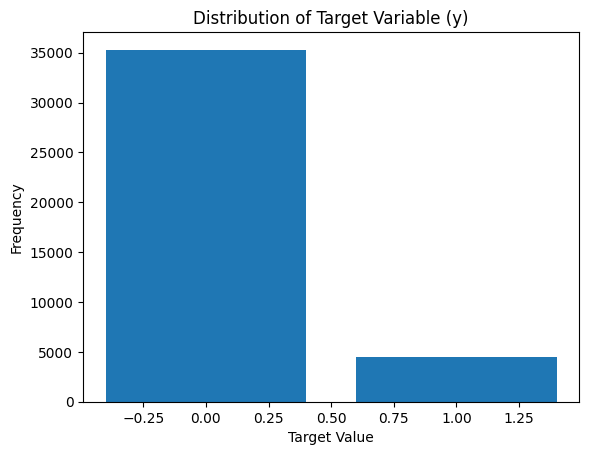

In [38]:
class_counts = combined_df['y'].value_counts().sort_values(ascending=False)
print('Class Frequencies: \n', class_counts)

majority_class = max(class_counts.values)
minority_class = min(class_counts.values)
imbalance_ratio = majority_class / minority_class
print(f"\nImbalance Ratio (Positive / Negative): {imbalance_ratio:.2f}")


plt.bar(combined_df['y'].unique(), combined_df['y'].value_counts())
plt.title('Distribution of Target Variable (y)')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()


**Data is highly imbalance, Applying Undersampling and Oversampling for Balance**

In [39]:
X = combined_df.drop('y', axis=1)
y = combined_df['y']

rus = RandomUnderSampler(random_state=42)
X_res_us, y_res_us = rus.fit_resample(X, y)

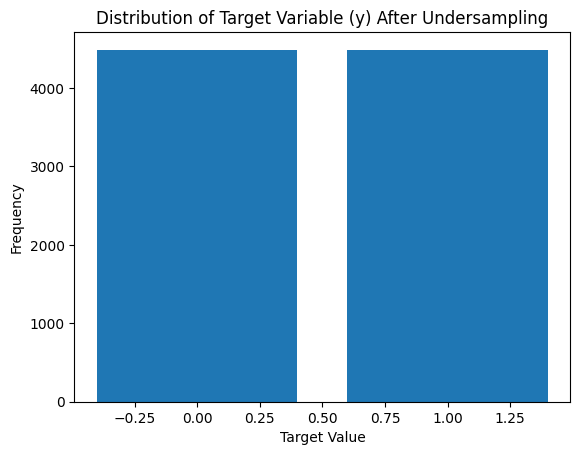

In [40]:
plt.bar(y_res_us.unique(), y_res_us.value_counts())
plt.title('Distribution of Target Variable (y) After Undersampling')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()


In [41]:
X_res_smote,y_res_smote=SMOTE().fit_resample(X,y)

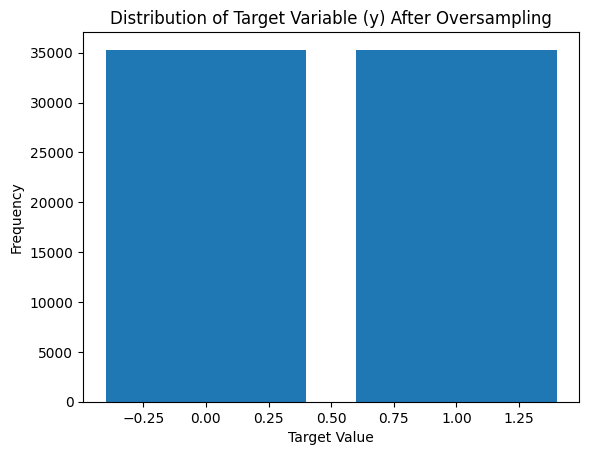

In [42]:
plt.bar(y_res_smote.unique(), y_res_smote.value_counts())
plt.title('Distribution of Target Variable (y) After Oversampling')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()


**Splitting Undersampled data into train and test dataset**

In [43]:
X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_res_us ,y_res_us, test_size=0.2, random_state=42)

print("Training set shapes:")
print(X_us_train.shape, y_us_train.shape)

print("Testing set shapes:")
print(X_us_test.shape, y_us_test.shape)

Training set shapes:
(7177, 24) (7177,)
Testing set shapes:
(1795, 24) (1795,)


**Model Selection**

**Models Performance on Undersampled dataset**

**1. Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression Performance for Undersampled dataset:
Accuracy: 0.8507
Precision: 0.8389
Recall: 0.8755
F1-score: 0.8568
ROC: 0.8502


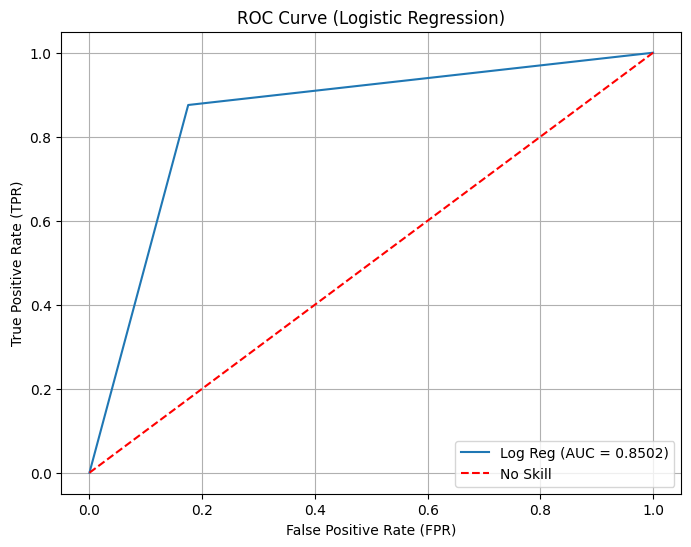

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

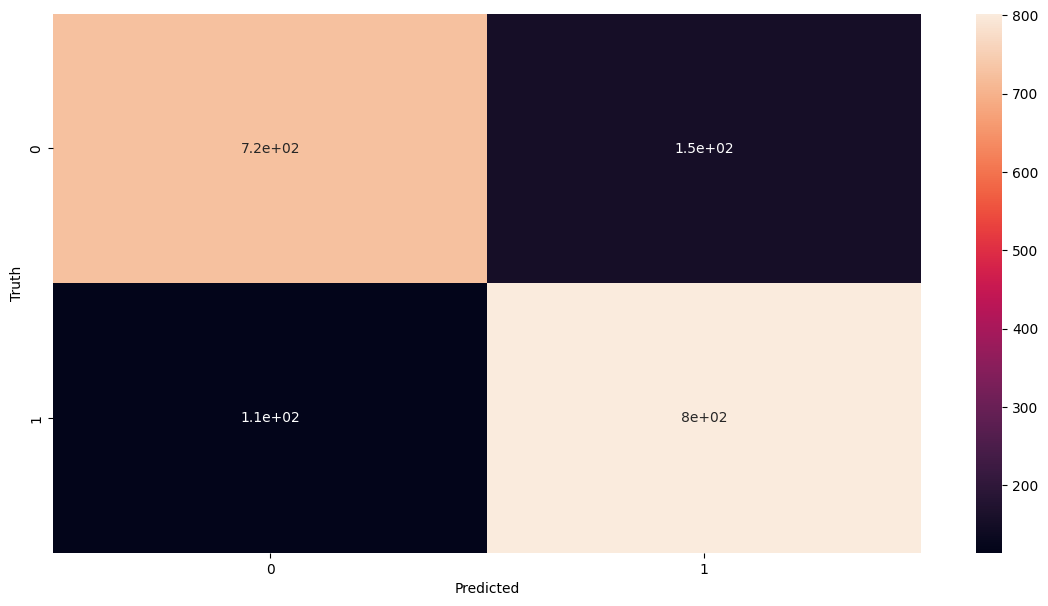

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix

lg = LogisticRegression()

lg.fit(X_us_train, y_us_train)

lg_y_pred = lg.predict(X_us_test)

lg_accuracy = accuracy_score(y_us_test, lg_y_pred)
lg_precision = precision_score(y_us_test, lg_y_pred)
lg_recall = recall_score(y_us_test, lg_y_pred)
lg_f1 = f1_score(y_us_test, lg_y_pred)

fpr_lg, tpr_lg, _ = roc_curve(y_us_test, lg_y_pred)
lg_roc_auc = auc(fpr_lg, tpr_lg)

lg_confusion_matrix = confusion_matrix(y_us_test, lg_y_pred)
print("Logistic Regression Performance for Undersampled dataset:")
print(f"Accuracy: {lg_accuracy:.4f}")
print(f"Precision: {lg_precision:.4f}")
print(f"Recall: {lg_recall:.4f}")
print(f"F1-score: {lg_f1:.4f}")

print(f"ROC: {lg_roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, label='Log Reg (AUC = %0.4f)' % lg_roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (Logistic Regression)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(lg_confusion_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

**2. SVM**


SVM Model Performance for Undersampled Data:
Accuracy: 0.7270
Precision: 0.7372
Recall: 0.7227
F1-score: 0.7299
ROC: 0.7271


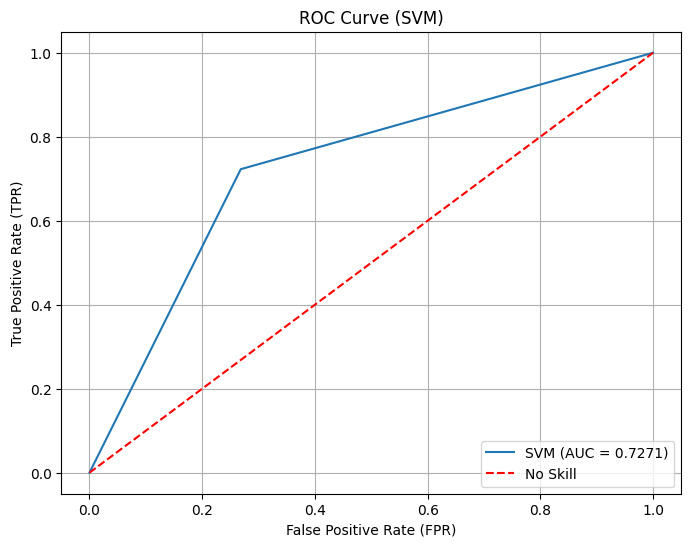

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

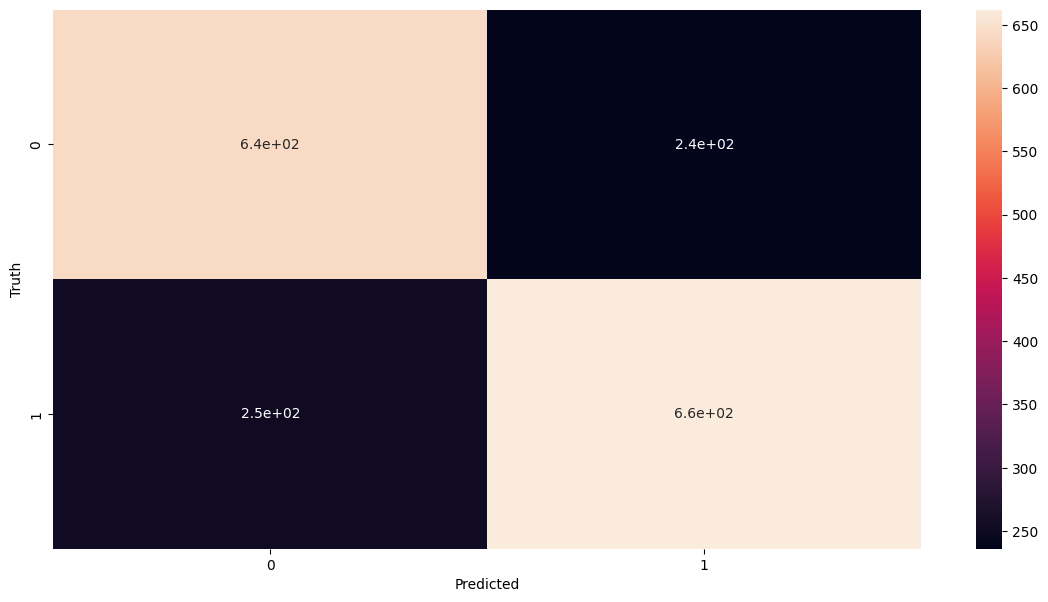

In [45]:
from sklearn.svm import SVC
svm = SVC()

svm.fit(X_us_train, y_us_train)

svm_y_pred = svm.predict(X_us_test)

svm_accuracy = accuracy_score(y_us_test, svm_y_pred)
svm_precision = precision_score(y_us_test, svm_y_pred)
svm_recall = recall_score(y_us_test, svm_y_pred)
svm_f1 = f1_score(y_us_test, svm_y_pred)

fpr_svm, tpr_svm, _ = roc_curve(y_us_test, svm_y_pred)
svm_roc_auc = auc(fpr_svm, tpr_svm)

svm_confusion_matrix = confusion_matrix(y_us_test, svm_y_pred)

print("\nSVM Model Performance for Undersampled Data:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1-score: {svm_f1:.4f}")

print(f"ROC: {svm_roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.4f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (SVM)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(svm_confusion_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

**3. Decision Tree**

Decision Tree Model Performance for Undersampled dataset:
Accuracy: 0.8423
Precision: 0.8474
Recall: 0.8428
F1-score: 0.8451
ROC: 0.8423


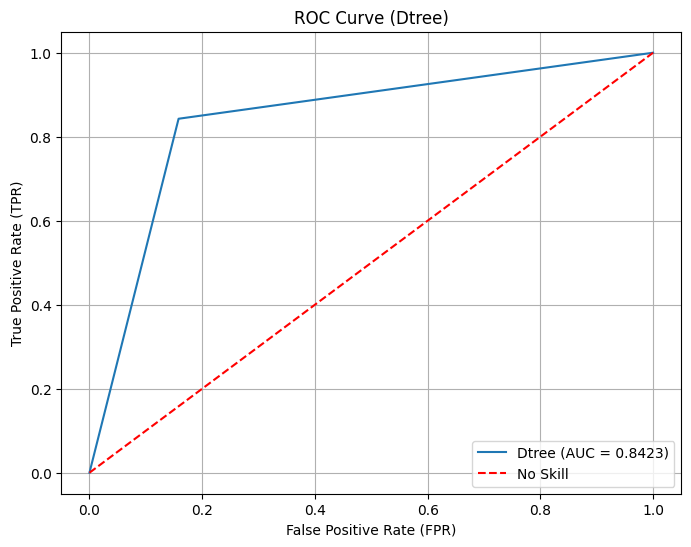

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

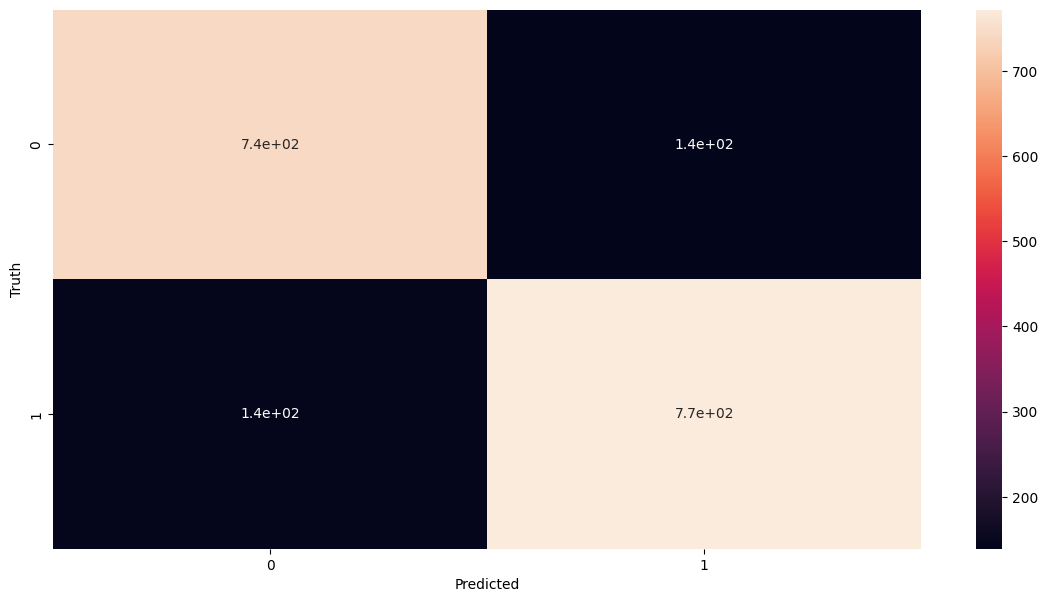

In [46]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

dtree.fit(X_us_train, y_us_train)

dtree_y_pred = dtree.predict(X_us_test)

dtree_accuracy = accuracy_score(y_us_test, dtree_y_pred)
dtree_precision = precision_score(y_us_test, dtree_y_pred)
dtree_recall = recall_score(y_us_test, dtree_y_pred)
dtree_f1 = f1_score(y_us_test, dtree_y_pred)


fpr_dtree, tpr_dtree, _ = roc_curve(y_us_test, dtree_y_pred)
dtree_roc_auc = auc(fpr_dtree, tpr_dtree)

dtree_confusion_matrix = confusion_matrix(y_us_test, dtree_y_pred)

print("Decision Tree Model Performance for Undersampled dataset:")
print(f"Accuracy: {dtree_accuracy:.4f}")
print(f"Precision: {dtree_precision:.4f}")
print(f"Recall: {dtree_recall:.4f}")
print(f"F1-score: {dtree_f1:.4f}")

print(f"ROC: {dtree_roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_dtree, tpr_dtree, label='Dtree (AUC = %0.4f)' % dtree_roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (Dtree)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(dtree_confusion_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

**4. Random Forest**

Random Forest Model Performance:
Accuracy: 0.8791
Precision: 0.8570
Recall: 0.9159
F1-score: 0.8855
ROC: 0.8783


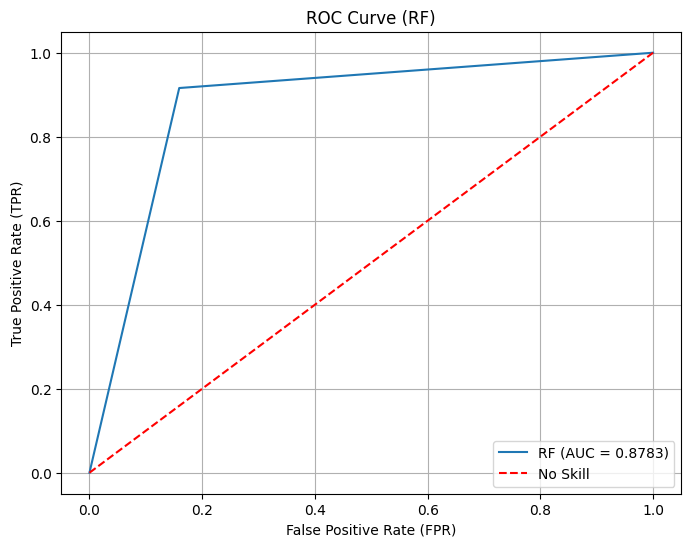

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

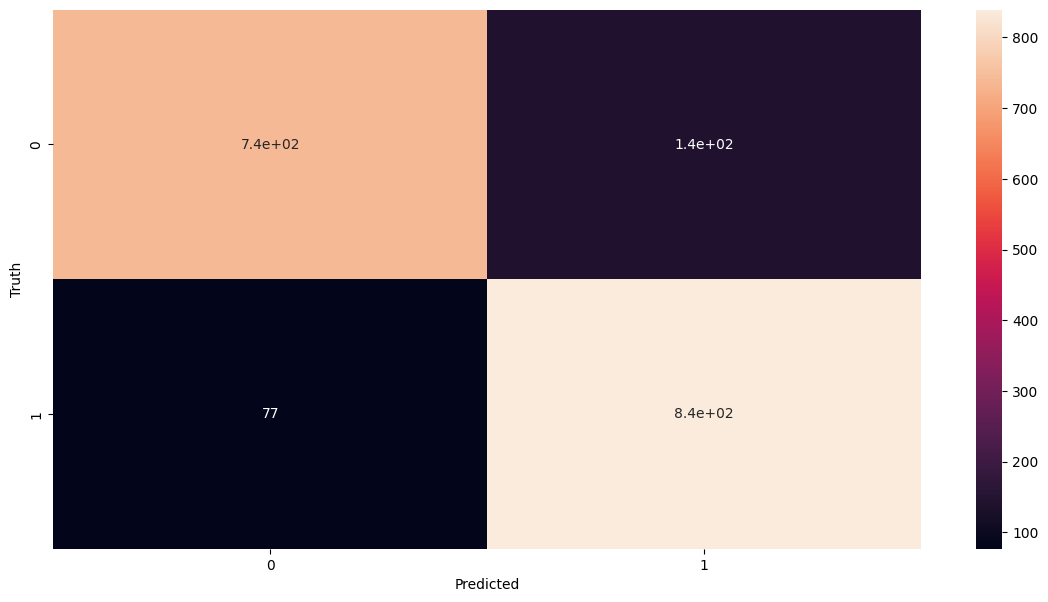

In [91]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_us_train, y_us_train)

rf_y_pred = rf.predict(X_us_test)

rf_accuracy = accuracy_score(y_us_test, rf_y_pred)
rf_precision = precision_score(y_us_test, rf_y_pred)
rf_recall = recall_score(y_us_test, rf_y_pred)
rf_f1 = f1_score(y_us_test, rf_y_pred)

fpr_rf, tpr_rf, _ = roc_curve(y_us_test, rf_y_pred)
rf_roc_auc = auc(fpr_rf, tpr_rf)

rf_confusion_matrix = confusion_matrix(y_us_test, rf_y_pred)

print("Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-score: {rf_f1:.4f}")

print(f"ROC: {rf_roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='RF (AUC = %0.4f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (RF)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(rf_confusion_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

**5. XGBoost**

XGBoost Model Performance:
Accuracy: 0.8719
Precision: 0.8558
Recall: 0.9007
F1-score: 0.8777
ROC: 0.8713


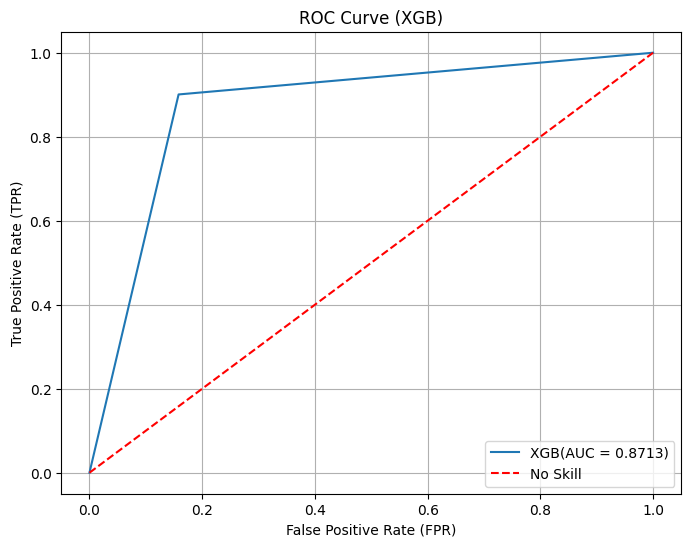

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

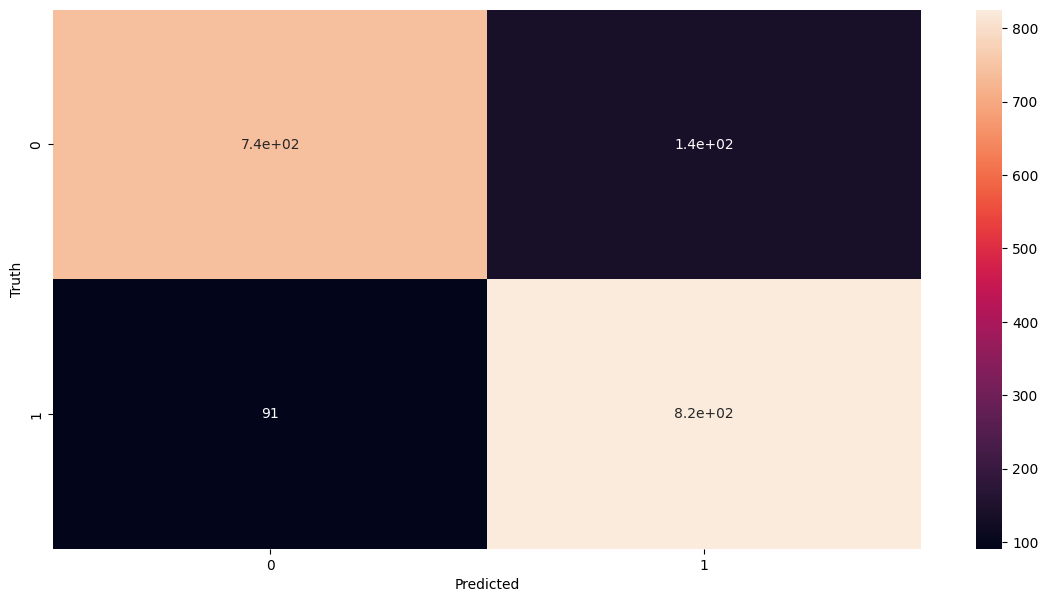

In [48]:
from xgboost import XGBClassifier
xgb= XGBClassifier(objective='binary:logistic', random_state=42)

xgb.fit(X_us_train, y_us_train)

xgb_y_pred = xgb.predict(X_us_test)

xgb_accuracy = accuracy_score(y_us_test, xgb_y_pred)
xgb_precision = precision_score(y_us_test, xgb_y_pred)
xgb_recall = recall_score(y_us_test, xgb_y_pred)
xgb_f1 = f1_score(y_us_test, xgb_y_pred)

fpr_xgb, tpr_xgb, _ = roc_curve(y_us_test, xgb_y_pred)
xgb_roc_auc = auc(fpr_xgb, tpr_xgb)

xgb_confusion_matrix = confusion_matrix(y_us_test, xgb_y_pred)


print("XGBoost Model Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-score: {xgb_f1:.4f}")
print(f"ROC: {xgb_roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label='XGB(AUC = %0.4f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (XGB)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(xgb_confusion_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3570, number of negative: 3607
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497422 -> initscore=-0.010311
[LightGBM] [Info] Start training from score -0.010311
XGBoost Model Performance:
Accuracy: 0.8869
Precision: 0.8619
Recall: 0.9269
F1-score: 0.8932
ROC: 0.8861


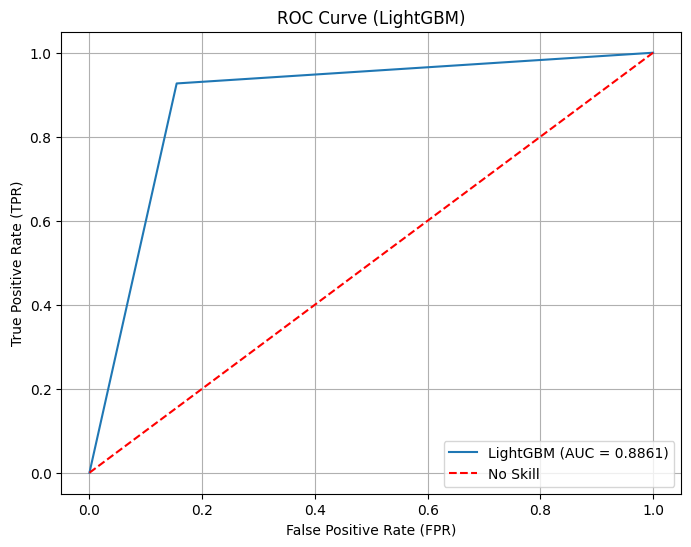

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

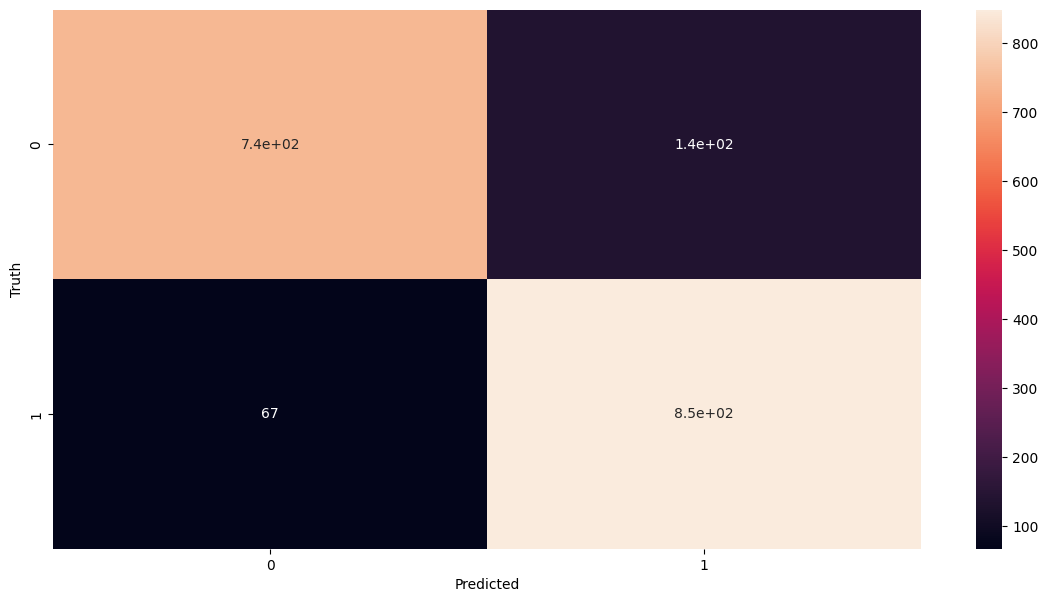

In [49]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(objective='binary', random_state=42)

lgb.fit(X_us_train, y_us_train)

lgb_y_pred = lgb.predict(X_us_test)

lgb_accuracy = accuracy_score(y_us_test, lgb_y_pred)
lgb_precision = precision_score(y_us_test, lgb_y_pred)
lgb_recall = recall_score(y_us_test, lgb_y_pred)
lgb_f1 = f1_score(y_us_test, lgb_y_pred)


fpr_lgb, tpr_lgb, _ = roc_curve(y_us_test, lgb_y_pred)
lgb_roc_auc = auc(fpr_lgb, tpr_lgb)

lgb_confusion_matrix = confusion_matrix(y_us_test, lgb_y_pred)

print("XGBoost Model Performance:")
print(f"Accuracy: {lgb_accuracy:.4f}")
print(f"Precision: {lgb_precision:.4f}")
print(f"Recall: {lgb_recall:.4f}")
print(f"F1-score: {lgb_f1:.4f}")
print(f"ROC: {lgb_roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM (AUC = %0.4f)' % lgb_roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (LightGBM)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(lgb_confusion_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

**Models Performance on SMOTE (OverSampled) Dataset**

In [50]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_res_smote ,y_res_smote, test_size=0.2, random_state=42)

print("Training set shapes:")
print(X_smote_train.shape, y_smote_train.shape)

print("Testing set shapes:")
print(X_smote_test.shape, y_smote_test.shape)

Training set shapes:
(56473, 24) (56473,)
Testing set shapes:
(14119, 24) (14119,)


**1. Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression Performance for Oversampled (SMOTE) dataset:
Accuracy: 0.8650
Precision: 0.8544
Recall: 0.8829
F1-score: 0.8684
ROC: 0.8648


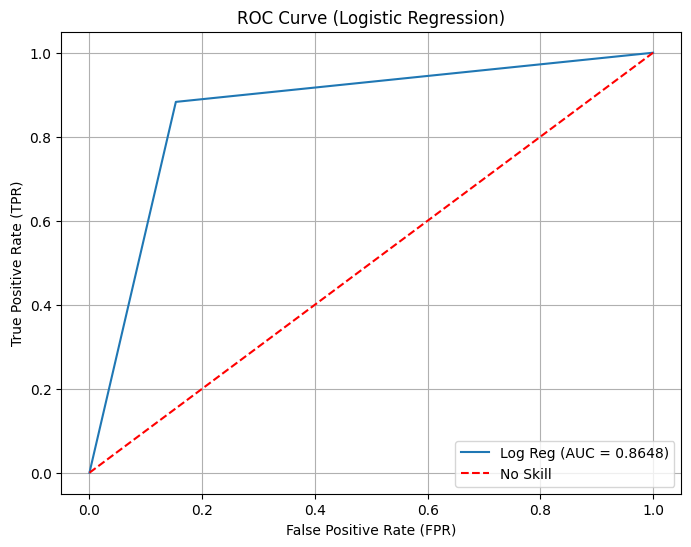

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

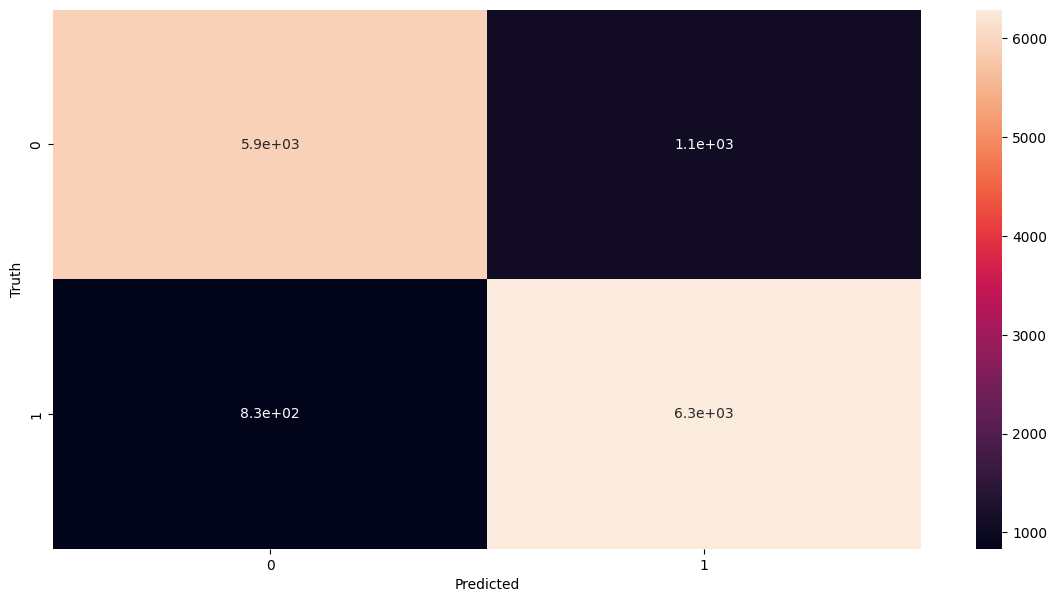

In [51]:
lg.fit(X_smote_train, y_smote_train)

lg_y_pred_smote = lg.predict(X_smote_test)

lg_accuracy_smote = accuracy_score(y_smote_test, lg_y_pred_smote)
lg_precision_smote = precision_score(y_smote_test, lg_y_pred_smote)
lg_recall_smote = recall_score(y_smote_test, lg_y_pred_smote)
lg_f1_smote = f1_score(y_smote_test, lg_y_pred_smote)

fpr_lg_smote, tpr_lg_smote, _smote = roc_curve(y_smote_test, lg_y_pred_smote)
lg_roc_auc_smote = auc(fpr_lg_smote, tpr_lg_smote)

lg_confusion_matrix_smote = confusion_matrix(y_smote_test, lg_y_pred_smote)
print("Logistic Regression Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {lg_accuracy_smote:.4f}")
print(f"Precision: {lg_precision_smote:.4f}")
print(f"Recall: {lg_recall_smote:.4f}")
print(f"F1-score: {lg_f1_smote:.4f}")

print(f"ROC: {lg_roc_auc_smote:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_lg_smote, tpr_lg_smote, label='Log Reg (AUC = %0.4f)' % lg_roc_auc_smote)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (Logistic Regression)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(lg_confusion_matrix_smote, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Logistic Regression Performance for Oversampled (SMOTE) dataset:
Accuracy: 0.7129
Precision: 0.7195
Recall: 0.7067
F1-score: 0.7130
ROC: 0.7130


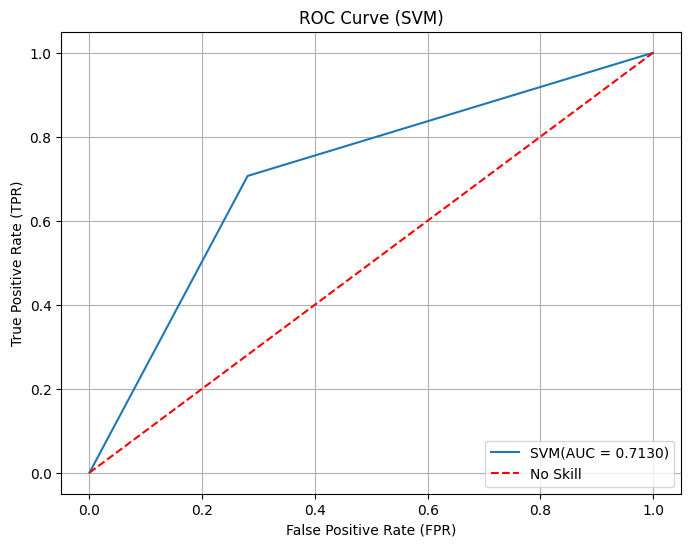

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

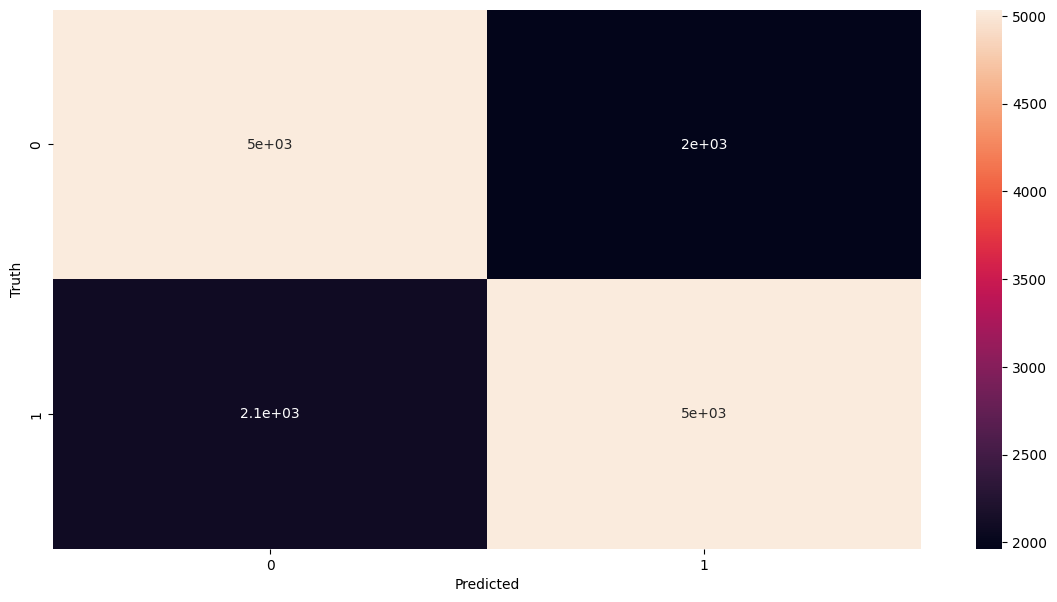

In [52]:
svm.fit(X_smote_train, y_smote_train)

svm_y_pred_smote = svm.predict(X_smote_test)

svm_accuracy_smote = accuracy_score(y_smote_test, svm_y_pred_smote)
svm_precision_smote = precision_score(y_smote_test, svm_y_pred_smote)
svm_recall_smote = recall_score(y_smote_test, svm_y_pred_smote)
svm_f1_smote = f1_score(y_smote_test, svm_y_pred_smote)

fpr_svm_smote, tpr_svm_smote, _smote = roc_curve(y_smote_test, svm_y_pred_smote)
svm_roc_auc_smote = auc(fpr_svm_smote, tpr_svm_smote)

svm_confusion_matrix_smote = confusion_matrix(y_smote_test, svm_y_pred_smote)
print("Logistic Regression Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {svm_accuracy_smote:.4f}")
print(f"Precision: {svm_precision_smote:.4f}")
print(f"Recall: {svm_recall_smote:.4f}")
print(f"F1-score: {svm_f1_smote:.4f}")

print(f"ROC: {svm_roc_auc_smote:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm_smote, tpr_svm_smote, label='SVM(AUC = %0.4f)' % svm_roc_auc_smote)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (SVM)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(svm_confusion_matrix_smote, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Decision Tree Performance for Oversampled (SMOTE) dataset:
Accuracy: 0.9219
Precision: 0.9241
Recall: 0.9210
F1-score: 0.9225
ROC: 0.9220


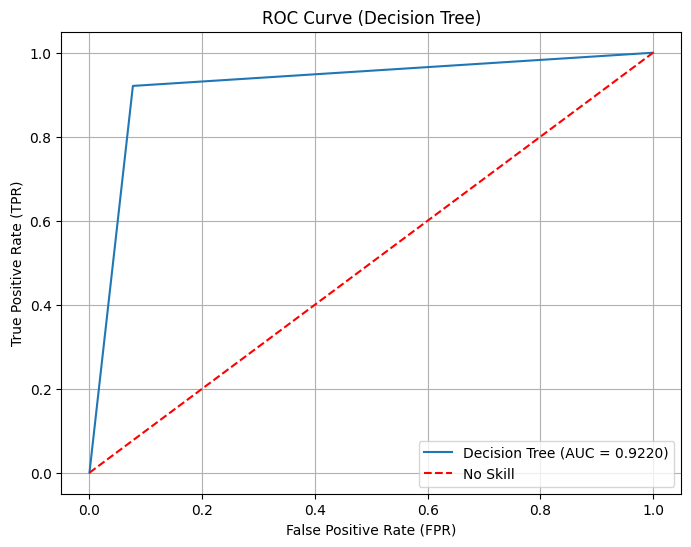

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

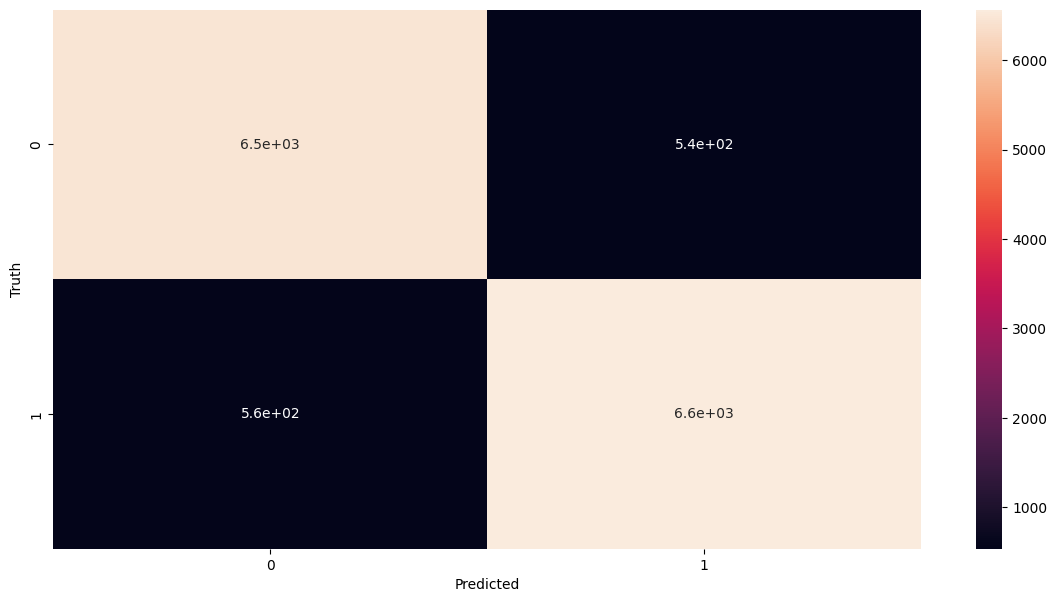

In [53]:
dtree.fit(X_smote_train, y_smote_train)

dtree_y_pred_smote = dtree.predict(X_smote_test)


dtree_accuracy_smote = accuracy_score(y_smote_test, dtree_y_pred_smote)
dtree_precision_smote = precision_score(y_smote_test, dtree_y_pred_smote)
dtree_recall_smote = recall_score(y_smote_test, dtree_y_pred_smote)
dtree_f1_smote = f1_score(y_smote_test, dtree_y_pred_smote)

fpr_dtree_smote, tpr_dtree_smote, _smote = roc_curve(y_smote_test, dtree_y_pred_smote)
dtree_roc_auc_smote = auc(fpr_dtree_smote, tpr_dtree_smote)

dtree_confusion_matrix_smote = confusion_matrix(y_smote_test, dtree_y_pred_smote)

print("Decision Tree Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {dtree_accuracy_smote:.4f}")
print(f"Precision: {dtree_precision_smote:.4f}")
print(f"Recall: {dtree_recall_smote:.4f}")
print(f"F1-score: {dtree_f1_smote:.4f}")

print(f"ROC: {dtree_roc_auc_smote:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_dtree_smote, tpr_dtree_smote, label='Decision Tree (AUC = %0.4f)' % dtree_roc_auc_smote)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (Decision Tree)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(dtree_confusion_matrix_smote, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


Random Forest Performance for Oversampled (SMOTE) dataset:
Accuracy: 0.9535
Precision: 0.9388
Recall: 0.9712
F1-score: 0.9547
ROC: 0.9534


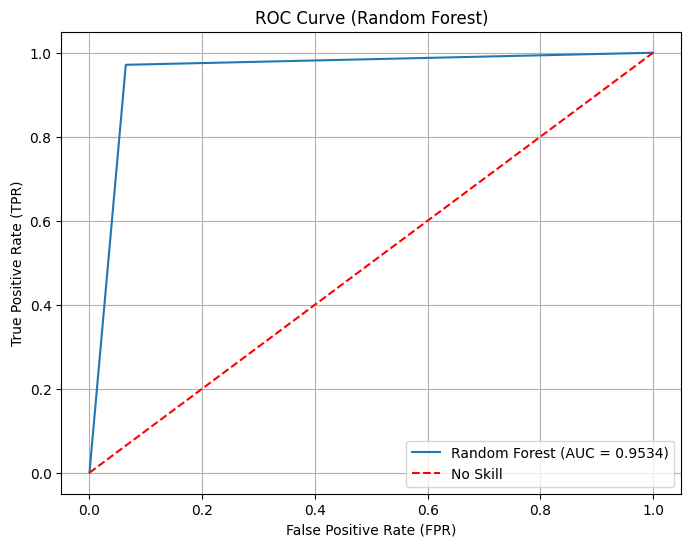

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

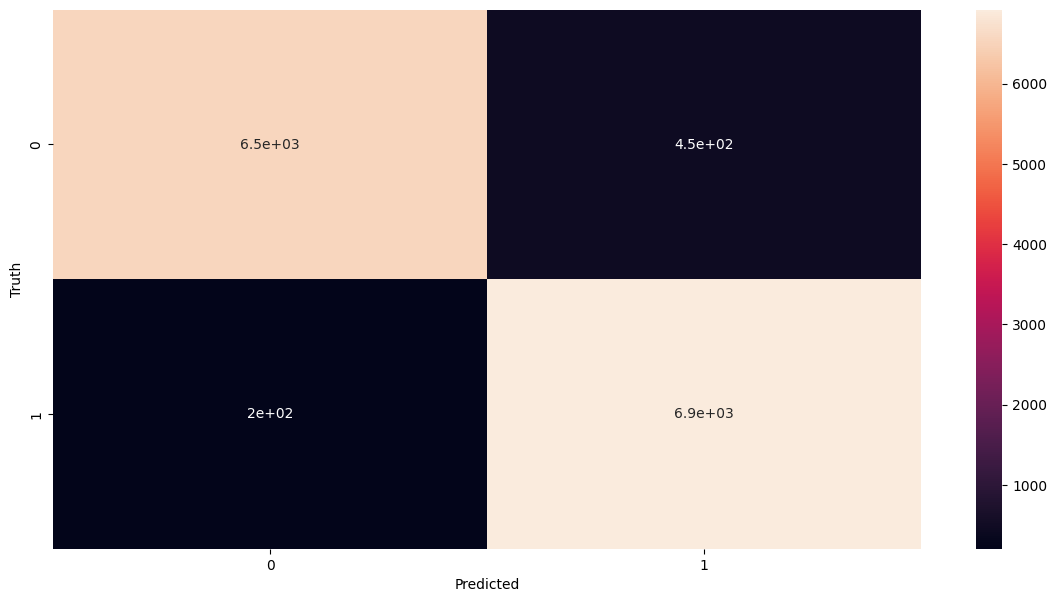

In [54]:
rf.fit(X_smote_train, y_smote_train)

rf_y_pred_smote = rf.predict(X_smote_test)

rf_accuracy_smote = accuracy_score(y_smote_test, rf_y_pred_smote)
rf_precision_smote = precision_score(y_smote_test, rf_y_pred_smote)
rf_recall_smote = recall_score(y_smote_test, rf_y_pred_smote)
rf_f1_smote = f1_score(y_smote_test, rf_y_pred_smote)

fpr_rf_smote, tpr_rf_smote, _smote = roc_curve(y_smote_test, rf_y_pred_smote)
rf_roc_auc_smote = auc(fpr_rf_smote, tpr_rf_smote)

rf_confusion_matrix_smote = confusion_matrix(y_smote_test, rf_y_pred_smote)

print("Random Forest Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {rf_accuracy_smote:.4f}")
print(f"Precision: {rf_precision_smote:.4f}")
print(f"Recall: {rf_recall_smote:.4f}")
print(f"F1-score: {rf_f1_smote:.4f}")

print(f"ROC: {rf_roc_auc_smote:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_smote, tpr_rf_smote, label='Random Forest (AUC = %0.4f)' % rf_roc_auc_smote)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (Random Forest)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(rf_confusion_matrix_smote, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


XGBoost Performance for Oversampled (SMOTE) dataset:
Accuracy: 0.9471
Precision: 0.9449
Recall: 0.9506
F1-score: 0.9477
ROC: 0.9471


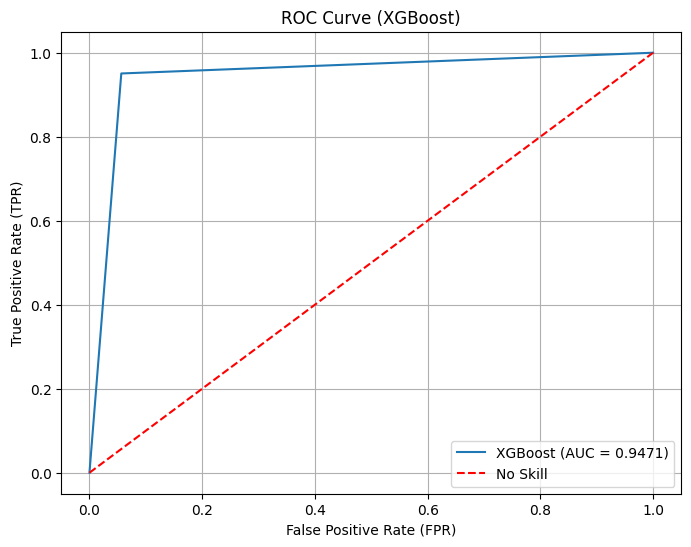

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

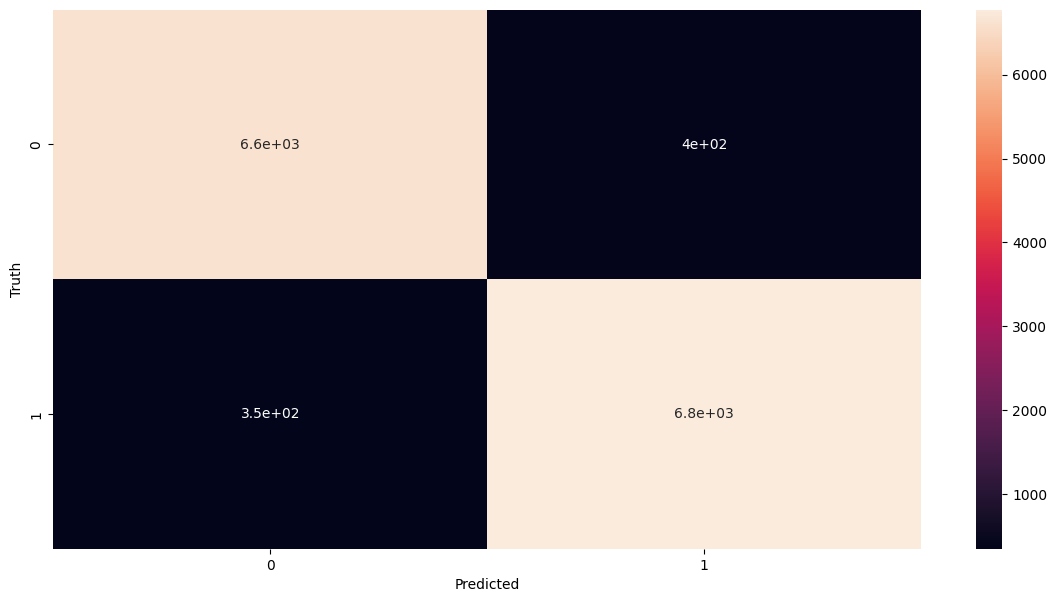

In [55]:
xgb.fit(X_smote_train, y_smote_train)

xgb_y_pred_smote = xgb.predict(X_smote_test)

xgb_accuracy_smote = accuracy_score(y_smote_test, xgb_y_pred_smote)
xgb_precision_smote = precision_score(y_smote_test, xgb_y_pred_smote)
xgb_recall_smote = recall_score(y_smote_test, xgb_y_pred_smote)
xgb_f1_smote = f1_score(y_smote_test, xgb_y_pred_smote)

fpr_xgb_smote, tpr_xgb_smote, _smote = roc_curve(y_smote_test, xgb_y_pred_smote)
xgb_roc_auc_smote = auc(fpr_xgb_smote, tpr_xgb_smote)

xgb_confusion_matrix_smote = confusion_matrix(y_smote_test, xgb_y_pred_smote)

print("XGBoost Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {xgb_accuracy_smote:.4f}")
print(f"Precision: {xgb_precision_smote:.4f}")
print(f"Recall: {xgb_recall_smote:.4f}")
print(f"F1-score: {xgb_f1_smote:.4f}")

print(f"ROC: {xgb_roc_auc_smote:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_smote, tpr_xgb_smote, label='XGBoost (AUC = %0.4f)' % xgb_roc_auc_smote)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (XGBoost)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(xgb_confusion_matrix_smote, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 28171, number of negative: 28302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5391
[LightGBM] [Info] Number of data points in the train set: 56473, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498840 -> initscore=-0.004639
[LightGBM] [Info] Start training from score -0.004639
LightGBM Performance for Oversampled (SMOTE) dataset:
Accuracy: 0.9472
Precision: 0.9370
Recall: 0.9599
F1-score: 0.9483
ROC: 0.9470


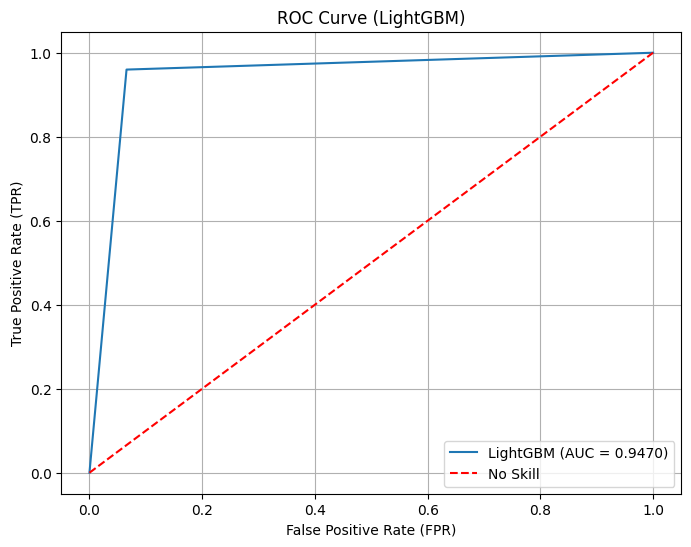

Confusion Matrix:


Text(145.72222222222223, 0.5, 'Truth')

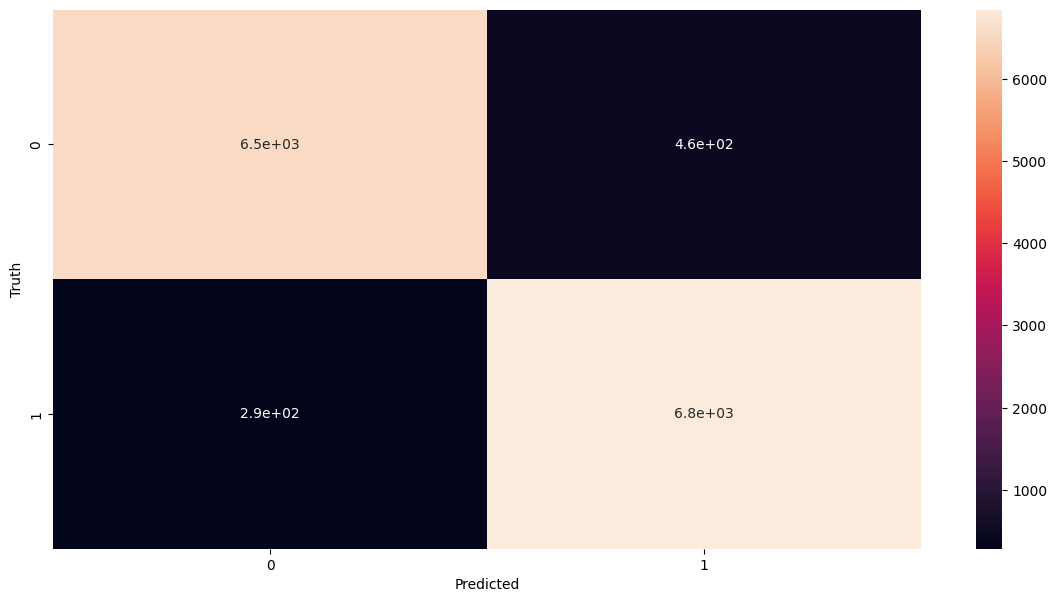

In [56]:
lgb.fit(X_smote_train, y_smote_train)

lgb_y_pred_smote = lgb.predict(X_smote_test)

lgb_accuracy_smote = accuracy_score(y_smote_test, lgb_y_pred_smote)
lgb_precision_smote = precision_score(y_smote_test, lgb_y_pred_smote)
lgb_recall_smote = recall_score(y_smote_test, lgb_y_pred_smote)
lgb_f1_smote = f1_score(y_smote_test, lgb_y_pred_smote)

fpr_lgb_smote, tpr_lgb_smote, _smote = roc_curve(y_smote_test, lgb_y_pred_smote)
lgb_roc_auc_smote = auc(fpr_lgb_smote, tpr_lgb_smote)

lgb_confusion_matrix_smote = confusion_matrix(y_smote_test, lgb_y_pred_smote)

print("LightGBM Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {lgb_accuracy_smote:.4f}")
print(f"Precision: {lgb_precision_smote:.4f}")
print(f"Recall: {lgb_recall_smote:.4f}")
print(f"F1-score: {lgb_f1_smote:.4f}")

print(f"ROC: {lgb_roc_auc_smote:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb_smote, tpr_lgb_smote, label='LightGBM (AUC = %0.4f)' % lgb_roc_auc_smote)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.title('ROC Curve (LightGBM)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Confusion Matrix:")
plt.figure(figsize=(14,7))
sns.heatmap(lgb_confusion_matrix_smote, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [57]:
result_table_us=pd.DataFrame({'Models':['LR','SVM','DT','RF','XGB','LGB'],
                              'Accuracy':[lg_accuracy,svm_accuracy,dtree_accuracy,rf_accuracy,xgb_accuracy,lgb_accuracy],
                              'Precision':[lg_precision,svm_precision,dtree_precision,rf_precision,xgb_precision,lgb_precision],
                              'Recall':[lg_recall,svm_recall,dtree_recall,rf_recall,xgb_recall,lgb_recall],
                              'F1':[lg_f1,svm_f1,dtree_f1,rf_f1,xgb_f1,lgb_f1],
                              'ROC-Curve':[lg_roc_auc,svm_roc_auc,dtree_roc_auc,rf_roc_auc,xgb_roc_auc,lgb_roc_auc]})

In [58]:
result_table_smote=pd.DataFrame({'Models':['LR','SVM','DT','RF','XGB','LGB'],
                              'Accuracy':[lg_accuracy_smote,svm_accuracy_smote,dtree_accuracy_smote,rf_accuracy_smote,xgb_accuracy_smote,lgb_accuracy_smote],
                              'Precision':[lg_precision_smote,svm_precision_smote,dtree_precision_smote,rf_precision_smote,xgb_precision_smote,lgb_precision_smote],
                              'Recall':[lg_recall_smote,svm_recall_smote,dtree_recall_smote,rf_recall_smote,xgb_recall_smote,lgb_recall_smote],
                              'F1':[lg_f1_smote,svm_f1_smote,dtree_f1_smote,rf_f1_smote,xgb_f1_smote,lgb_f1_smote],
                              'ROC-Curve':[lg_roc_auc_smote,svm_roc_auc_smote,dtree_roc_auc_smote,rf_roc_auc_smote,xgb_roc_auc_smote,lgb_roc_auc_smote]})

In [59]:
result_table_us.sort_values(by='ROC-Curve',ascending=False).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

,Models,Accuracy,Precision,Recall,F1,ROC-Curve
5,LGB,0.886908,0.861929,0.926856,0.893214,0.886067
3,RF,0.879109,0.856997,0.915939,0.885488,0.878333
4,XGB,0.871866,0.855809,0.900655,0.877660,0.871260
0,LR,0.850696,0.838912,0.875546,0.856838,0.850173
2,DT,0.842340,0.847420,0.842795,0.845101,0.842330
1,SVM,0.727019,0.737194,0.722707,0.729879,0.727110


In [60]:
result_table_smote.sort_values(by='ROC-Curve',ascending=False).style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

,Models,Accuracy,Precision,Recall,F1,ROC-Curve
3,RF,0.953538,0.938814,0.971228,0.954746,0.953372
4,XGB,0.947093,0.944894,0.950596,0.947737,0.947060
5,LGB,0.947163,0.936978,0.959860,0.948281,0.947044
2,DT,0.921949,0.924095,0.920982,0.922536,0.921958
0,LR,0.865005,0.854407,0.882947,0.868443,0.864837
1,SVM,0.712940,0.719491,0.706667,0.713021,0.712999


**Dataset balanced via SMOTE performed very well using Random Forest Algorithm.**
**Investigating further for selection of most suitable Model.**

**Model Evaluation**

*Tuning top three best performing models*

**1. Random Forest**

In [61]:
rf = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=42)


rf.fit(X_smote_train, y_smote_train)

rf_y_pred_smote = rf.predict(X_smote_test)

rf_accuracy_smote = accuracy_score(y_smote_test, rf_y_pred_smote)
rf_precision_smote = precision_score(y_smote_test, rf_y_pred_smote)
rf_recall_smote = recall_score(y_smote_test, rf_y_pred_smote)
rf_f1_smote = f1_score(y_smote_test, rf_y_pred_smote)

fpr_rf_smote, tpr_rf_smote, _smote = roc_curve(y_smote_test, rf_y_pred_smote)
rf_roc_auc_smote = auc(fpr_rf_smote, tpr_rf_smote)

print("Random Forest Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {rf_accuracy_smote:.4f}")
print(f"Precision: {rf_precision_smote:.4f}")
print(f"Recall: {rf_recall_smote:.4f}")
print(f"F1-score: {rf_f1_smote:.4f}")

print(f"ROC: {rf_roc_auc_smote:.4f}")


Random Forest Performance for Oversampled (SMOTE) dataset:
Accuracy: 0.9524
Precision: 0.9361
Recall: 0.9721
F1-score: 0.9537
ROC: 0.9522


In [62]:
lgb = LGBMClassifier(objective='binary', random_state=42, n_estimators=400, max_depth=25, learning_rate=0.1)

lgb.fit(X_smote_train, y_smote_train)

lgb_y_pred_smote = lgb.predict(X_smote_test)

lgb_accuracy_smote = accuracy_score(y_smote_test, lgb_y_pred_smote)
lgb_precision_smote = precision_score(y_smote_test, lgb_y_pred_smote)
lgb_recall_smote = recall_score(y_smote_test, lgb_y_pred_smote)
lgb_f1_smote = f1_score(y_smote_test, lgb_y_pred_smote)

fpr_lgb_smote, tpr_lgb_smote, _smote = roc_curve(y_smote_test, lgb_y_pred_smote)
lgb_roc_auc_smote = auc(fpr_lgb_smote, tpr_lgb_smote)

lgb_confusion_matrix_smote = confusion_matrix(y_smote_test, lgb_y_pred_smote)

print("LightGBM Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {lgb_accuracy_smote:.4f}")
print(f"Precision: {lgb_precision_smote:.4f}")
print(f"Recall: {lgb_recall_smote:.4f}")
print(f"F1-score: {lgb_f1_smote:.4f}")

print(f"ROC: {lgb_roc_auc_smote:.4f}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 28171, number of negative: 28302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5391
[LightGBM] [Info] Number of data points in the train set: 56473, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498840 -> initscore=-0.004639
[LightGBM] [Info] Start training from score -0.004639
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > n

In [63]:
xgb= XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=300, max_depth=15, learning_rate=0.1)

xgb.fit(X_smote_train, y_smote_train)

xgb_y_pred_smote = xgb.predict(X_smote_test)

xgb_accuracy_smote = accuracy_score(y_smote_test, xgb_y_pred_smote)
xgb_precision_smote = precision_score(y_smote_test, xgb_y_pred_smote)
xgb_recall_smote = recall_score(y_smote_test, xgb_y_pred_smote)
xgb_f1_smote = f1_score(y_smote_test, xgb_y_pred_smote)

fpr_xgb_smote, tpr_xgb_smote, _smote = roc_curve(y_smote_test, xgb_y_pred_smote)
xgb_roc_auc_smote = auc(fpr_xgb_smote, tpr_xgb_smote)
xgb_confusion_matrix_smote = confusion_matrix(y_smote_test, xgb_y_pred_smote)

print("XGBoost Performance for Oversampled (SMOTE) dataset:")
print(f"Accuracy: {xgb_accuracy_smote:.4f}")
print(f"Precision: {xgb_precision_smote:.4f}")
print(f"Recall: {xgb_recall_smote:.4f}")
print(f"F1-score: {xgb_f1_smote:.4f}")
print(f"ROC: {xgb_roc_auc_smote:.4f}")

XGBoost Performance for Oversampled (SMOTE) dataset:
Accuracy: 0.9532
Precision: 0.9470
Recall: 0.9610
F1-score: 0.9540
ROC: 0.9531


**Even After Models' Evaluation, 1st Random Forest via SMOTE performed the best, So using it as final model.**

**Checking if RF is overfitting or not.**

In [64]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X_res_smote ,y_res_smote, test_size=0.2)

rf1 = RandomForestClassifier(random_state=42)
rf1.fit(X1_train, y1_train)

train_score_before = rf1.score(X1_train, y1_train)
val_score_before = rf1.score(X1_val, y1_val)


print("Training Score before:", train_score_before)
print("Validation Score before:", val_score_before)

Training Score before: 0.9999822924229278
Validation Score before: 0.9509172037679723


In [65]:
#Commenting out this code as it takes very long to run.
'''
from sklearn.model_selection import GridSearchCV, StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'max_depth': [3, 5, 8, 10, 12, 15],
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['sqrt', 'log2']
}


rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=skf, scoring='f1_macro', return_train_score=False, verbose=2)
rf_clf.fit(X1_train, y1_train)


best_rf_model = rf_clf.best_estimator_
predictions = best_rf_model.predict(X1_val)

print("Best hyperparameters:", rf_clf.best_params_)
'''


' \nfrom sklearn.model_selection import GridSearchCV, StratifiedKFold\n\nskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)\n\nparam_grid = {\n    \'max_depth\': [3, 5, 8, 10, 12, 15],\n    \'n_estimators\': [100, 200, 300, 400],\n    \'max_features\': [\'sqrt\', \'log2\'] \n}\n\n\nrf_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=skf, scoring=\'f1_macro\', return_train_score=False, verbose=2)\nrf_clf.fit(X1_train, y1_train)\n\n\nbest_rf_model = rf_clf.best_estimator_\npredictions = best_rf_model.predict(X1_val)\n\nprint("Best hyperparameters:", rf_clf.best_params_)\n'

In [82]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X_res_smote ,y_res_smote, test_size=0.2)

rf_best = RandomForestClassifier(random_state=42, max_depth=11, max_features='sqrt', n_estimators=200)
rf_best.fit(X1_train, y1_train)

train_score_after = rf_best.score(X1_train, y1_train)
val_score_after = rf_best.score(X1_val, y1_val)


print("Training Score After:", train_score_after)
print("Validation Score After:", val_score_after)

Training Score After: 0.9337736617498628
Validation Score After: 0.9208867483532828


*Now that the difference btw Validation Score and Training Score is relatively less, the new scores provide a positive trend. This indicates that the model is likely generalizing better and learning patterns that apply to unseen data.*

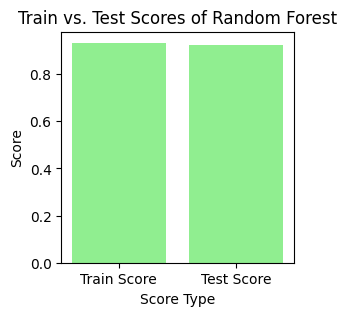

In [71]:
train_score = 0.9334
val_score = 0.9232
scores = [train_score, val_score]
labels = ['Train Score', 'Test Score']

plt.figure(figsize=(3, 3))
plt.bar(labels, scores,color='lightgreen')
plt.title('Train vs. Test Scores of Random Forest')
plt.xlabel('Score Type')
plt.ylabel('Score')
plt.show()


**Finalizing the Model**

In [92]:
rf_best = RandomForestClassifier(random_state=42, max_depth=11, max_features='sqrt', n_estimators=200)
rf_best.fit(X_smote_train, y_smote_train)

RandomForestClassifier(max_depth=11, n_estimators=200, random_state=42)

In [93]:
rf_best.predict(X_smote_test)

array([0, 0, 0, ..., 1, 0, 1])

In [94]:
import pickle
filename = 'bank_model.pkl'
pickle.dump(rf_best, open(filename, 'wb'))